# LADDMS lidar trajectory data tutorial
#### Last updated: 08/18/2024
#### https://ndot-laddms.org

This tutorial will cover:
1) Structure and contents of the LADDMS data.
2) Calculating derivative trajectory quantities.
3) Performing basic spatial analysis on the data using some secondary geometry.
4) Plotting trajectories and other geometry on an interactive map.

In [2]:
import matplotlib.pyplot as plt
import shapely as shp
import geopandas as gpd
import numpy as np
import datetime as dt
import folium
import zoneinfo
import json
import random
import warnings

## Load the trajectory dataset and show some basic info

Loading data assumes that the files are located in the same directory as this notebook. Download the data file from [https://vu.edu/laddms-data-snippet](https://vu.edu/laddms-data-snippet). See `README.md` for more information about data fields.

In [3]:
# Load the entire data file.
# Structure is a JSON with a single list of trajectory key:value dictionaries.
with open('./sample_data.json', 'r') as f:
    trajectories = json.load(f)
    print(f"Loaded {len(trajectories)} object trajectories.")

Loaded 11636 object trajectories.


In [4]:
# Print the keys and values in the first trajectory dictionary.
# Note the magnitude for various data fields.
for key, value in trajectories[0].items():
    if not isinstance(value, list):
        print(key, ": ", value)
    else:
        # If the value type is a list, just print the first few values.
        print(key, ": ", value[:6], "...")

object_id :  3349568
location_id :  7
classification :  VEHICLE
sub_classification :  truck
obj_length :  8.909214423029047
obj_width :  2.7810029160348995
obj_height :  3.2576541652679443
avg_filtered_confidence :  0.6216886437064723
ts :  [0.071224, 0.1712, 0.271224, 0.471297, 0.571265, 0.67131] ...
vel_x :  [0.0002913409234998061, 5.581452963879323e-09, -0.00015101015160697866, 0.0010393583370085428, 0.000857863293314793, -0.00014653192234738674] ...
vel_y :  [-0.029722255633327033, 0.00013807057647190392, 0.04462758746632097, 0.08179885606272358, 0.05741870482718205, -0.009798537694042481] ...
utm_x :  [517326.0185205772, 517326.0712992706, 517326.0363751517, 517325.9161638559, 517325.9382117672, 517325.63362239645] ...
utm_y :  [4003929.261780963, 4003929.061233937, 4003929.1044034907, 4003929.400181917, 4003929.3722253307, 4003930.305875497] ...


In [5]:
# Inspect the unique classes and locations present in the dataset.
classes = set([traj['classification'] for traj in trajectories])
print("Available classes:", classes)
locations = set([traj['location_id'] for traj in trajectories])
print("Available locations:", locations)

Available classes: {'VEHICLE', 'UNKNOWN', 'LARGE_VEHICLE', 'PERSON', 'BICYCLE'}
Available locations: {1, 2, 3, 4, 5, 6, 7, 8}


## Calculate and plot some speed statistics

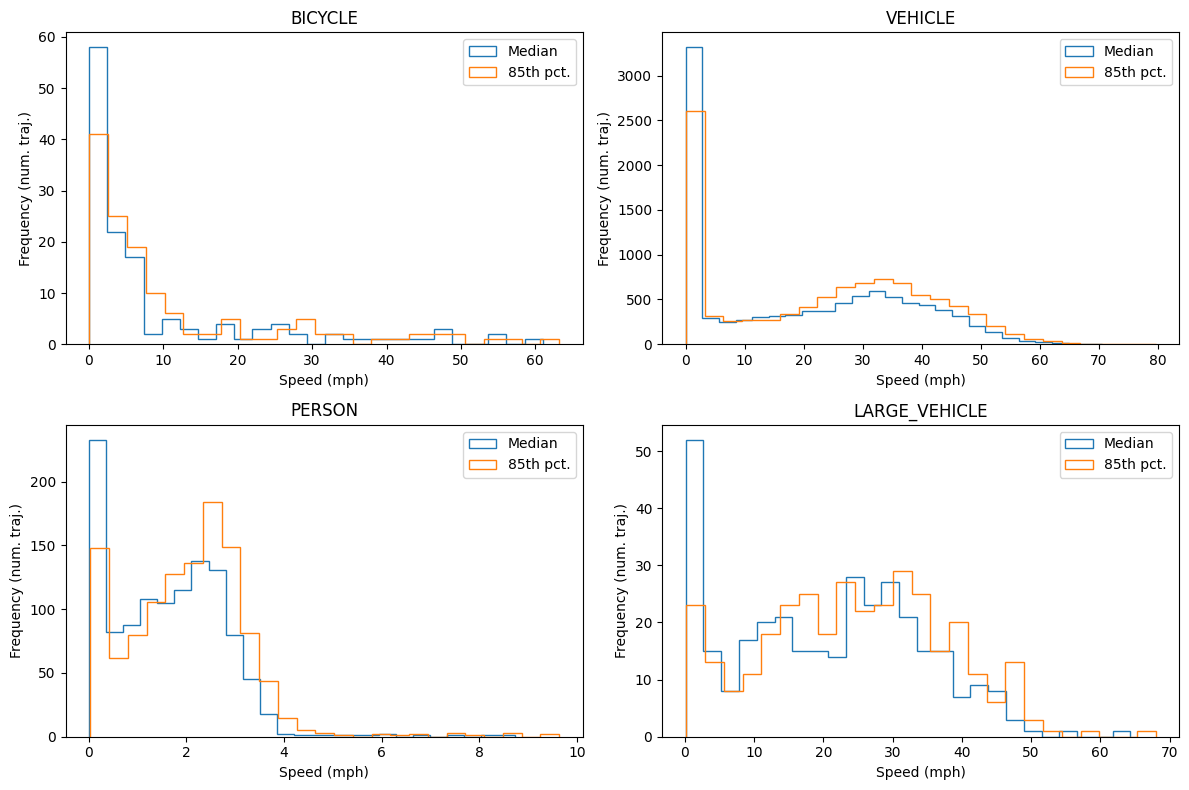

In [6]:
# Make a 2x2 subplot of trajectory speed histogram for each of four known object classes.
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# Iterate across pairs of class name and subplot. 
# `axs.flatten()` unpacks the 2D array of axes in the subplots to a vector.
for c, ax in zip(['BICYCLE', 'VEHICLE', 'PERSON', 'LARGE_VEHICLE'], axs.flatten()):
    median_speeds = []
    pct85_speeds = []
    # For trajectories matching the current class, calculate median and 85th percentile speed.
    # Append results to the above lists.
    for traj in trajectories:
        if traj['classification'] == c:
            # Calculate RSS of x- and y-component velocities (m/s), then convert to miles/hour.
            traj_speed_mph = np.sqrt(np.array(traj['vel_x'])**2 + np.array(traj['vel_y'])**2) * 2.23694
            median_speeds.append(np.quantile(traj_speed_mph, 0.5))
            pct85_speeds.append(np.quantile(traj_speed_mph, 0.85))
    # Plot median and 85th percentile histograms separately.
    ax.hist(median_speeds, bins=25, histtype='step', fill=False, label="Median")
    ax.hist(pct85_speeds, bins=25, histtype='step', fill=False, label="85th pct.")
    ax.set_xlabel("Speed (mph)")
    ax.set_ylabel("Frequency (num. traj.)")
    ax.set_title(c)
    ax.legend()
plt.tight_layout()
plt.show()

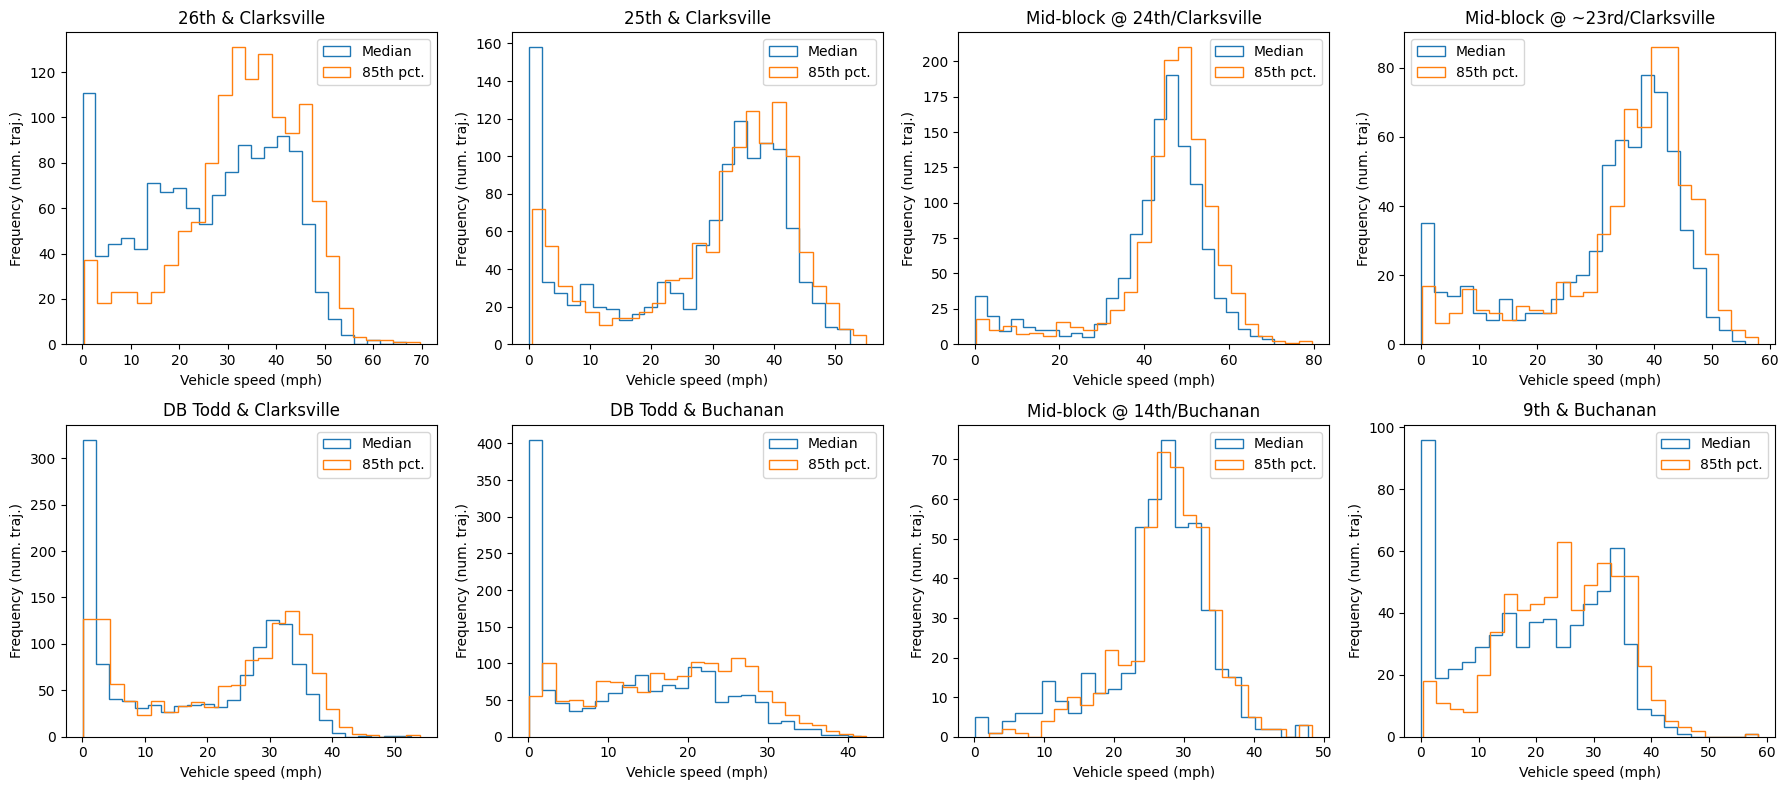

In [7]:
# Make a 2x4 subplot for each of eight locations.
loc_names = ['26th & Clarksville', '25th & Clarksville', 'Mid-block @ 24th/Clarksville',
             'Mid-block @ ~23rd/Clarksville', 'DB Todd & Clarksville', 'DB Todd & Buchanan',
             'Mid-block @ 14th/Buchanan', '9th & Buchanan']
fig, axs = plt.subplots(2, 4, figsize=(18, 8))
# Iterate across triples of location index, location name, and subplot. 
# `axs.flatten()` unpacks the 2D array of axes in the subplots to a vector.
for loc, loc_name, ax in zip(range(1, len(loc_names)+1), loc_names, axs.flatten()):
    median_speeds = []
    pct85_speeds = []
    # For trajectories matching the current location, calculate median and 85th percentile speed.
    for traj in trajectories:
        if traj['location_id'] == loc:
            # Only include objects that were a vehicle type.
            if traj['classification'] in ('VEHICLE', 'LARGE_VEHICLE'):
                # Calculate RSS of x- and y-component velocities (m/s), then convert to miles/hour.
                traj_speed_mph = np.sqrt(np.array(traj['vel_x'])**2 + np.array(traj['vel_y'])**2) * 2.23694
                # Drop trajectories that had a 95th percentile speed less than 2mph (i.e., parked cars).
                if np.quantile(traj_speed_mph, 0.95) < 2:
                    continue
                median_speeds.append(np.quantile(traj_speed_mph, 0.5))
                pct85_speeds.append(np.quantile(traj_speed_mph, 0.85))
    # Plot median and 85th percentile histograms separately.
    ax.hist(median_speeds, bins=25, histtype='step', fill=False, label="Median")
    ax.hist(pct85_speeds, bins=25, histtype='step', fill=False, label="85th pct.")
    ax.set_xlabel("Vehicle speed (mph)")
    ax.set_ylabel("Frequency (num. traj.)")
    ax.set_title(loc_name)
    ax.legend()
plt.tight_layout()
plt.show()

## Load some polygon zones and calculate geometric intersection

In [8]:
# This geo-JSON file contains a roadway zone drawn roughly around each lidar installation.
# The file was created on https://geojson.io/
geojson_path = 'location_zones.geojson'
gdf = gpd.read_file(geojson_path)
gdf = gdf.explode(index_parts=True).reset_index(drop=True)
# Coordinate reference system of the geometry is EPSG:4326 (WGS84), 
#  which is standard latitude/longitude as we normally use it.
gdf = gdf.set_crs(epsg=4326)
# The lidar data is in UTM coordinates, which projects the globe onto a flat Cartesian plane.
# There are different UTM zones for portions of the US. This EPSG:32616 includes Nashville.
# We convert the roadway zones in the Geojson to UTM instead of converting the trajectories.
gdf = gdf.to_crs(epsg=32616)
print(gdf)
zones = gdf.to_dict(orient='index')
# Create a dictionary of {location ID: polygon geometry}.
zones = {r['location_id']: r['geometry'] for r in zones.values()}
print(zones)

   location_id                                           geometry
0            1  POLYGON ((516289.239 4004654.547, 516288.187 4...
1            2  POLYGON ((516437.501 4004565.263, 516436.184 4...
2            3  POLYGON ((516561.879 4004471.922, 516532.711 4...
3            4  POLYGON ((516729.559 4004360.745, 516721.236 4...
4            5  POLYGON ((516868.796 4004269.499, 516868.123 4...
5            6  POLYGON ((516976.059 4003960.322, 516979.476 4...
6            7  POLYGON ((517251.186 4003947.837, 517251.336 4...
7            8  POLYGON ((517823.898 4004013.058, 517827.431 4...
{1: <POLYGON ((516289.239 4004654.547, 516288.187 4004649.155, 516286.491 400464...>, 2: <POLYGON ((516437.501 4004565.263, 516436.184 4004559.866, 516432.318 400455...>, 3: <POLYGON ((516561.879 4004471.922, 516532.711 4004490.116, 516526.297 400447...>, 4: <POLYGON ((516729.559 4004360.745, 516721.236 4004350.026, 516776.672 400430...>, 5: <POLYGON ((516868.796 4004269.499, 516868.123 4004262.491, 516

In [9]:
def trajectories_to_linestrings(trajectory_dictioinaries, simplify=1):
    """
    Converts trajectory UTM coordinate lists into linestring geometry.
    :param trajectory_dictionaries: list of dictionaries, each containing trajectory data; keys 'utm_x' and 'utm_y' are used.
    :param simplify: simplification factor for linestring gemetry; takes every N points.
    """
    # LIST[0::N] gets the Nth element of LIST; when N=1, it returns the entire list
    return [shp.geometry.LineString([(x, y) for x, y in zip(traj['utm_x'][0::simplify], traj['utm_y'][0::simplify])]) 
            for traj in trajectory_dictioinaries]

In [10]:
def calculate_zone_intersection(trajectory_linestrings, zone_polygons):
    """
    Generates count of number of intersecting trajectories for each zone polygon, as {polygon_id: count}
    :param trajectory_linestrings: list of shapely linestring geometries.
    :param zone_polygons: dictionary of format {polygon_id: polygon shapely geometry object}, assumed same CRS as linestrings
    """
    zone_counts = {}
    for zi, z_poly in zone_polygons.items():
        count = 0
        for t in trajectory_linestrings:
            if t.intersects(z_poly):
                count += 1
        zone_counts[zi] = count
    return zone_counts

In [11]:
def filter_trajectories_by_intersection(trajectory_linestrings, zone_polygons):
    """
    Generates filtered list of trajectory linestrings, those that intersect with any of the zone polygons.
    :param trajectory_linestrings: list of shapely linestring geometries.
    :param zone_polygons: dictionary of format {polygon_id: polygon shapely geometry object}, assumed same CRS as linestrings
    """
    filtered = []
    for t in trajectory_linestrings:
        for zi, z_poly in zone_polygons.items():
            if t.intersects(z_poly):
                filtered.append(t)
                break
    return filtered

In [12]:
# Calculate the number of pedestrian trajectories entering the roadway at any point at each location.
# Crossing at a crosswalk would likely intersect the zone.

# First, filter the data for pedestrians.
ped_data = [t for t in trajectories if t['classification'] == 'PERSON']
# Convert the trajectory data dictionaries to shapely linestrings. This geometric object
#  helps in comparison to other geometry (e.g., intersection).
ped_lines = trajectories_to_linestrings(ped_data)
# Calculate the number of pedestrian linestrings intersecting each zone.
peds_by_zone = calculate_zone_intersection(ped_lines, zones)
print("Pedestrian trajectories by roadway zone:", peds_by_zone)

Pedestrian trajectories by roadway zone: {1: 18, 2: 7, 3: 0, 4: 0, 5: 6, 6: 36, 7: 4, 8: 11}


## Plot trajectories and zones on a base map
This code has scalability limitations due to the interactive plotting backend. However, it is helpful to generate a familiar base map and check alignment based on the ground truth. If you are trying to plot thousands of trajectories, you might need to switch to a static plotting backend.

In [ ]:
def plot_trajectories(linestrings, 
                      polygons_geodataframe=None, 
                      polygons_tooltip=False, 
                      polygon_color_dict=None,
                      save_html_filepath=None):
    """
    Plot linestrings on an OpenStreetMap base map. Optionally, display polygon zones on the same map.
    :param linestrings: list of Shapely linestring geometry objects
    :param polygons_geodataframe: GeoDataFrame with 'location_id' and 'geometry' (polygon) columns
    :param polygons_tooltip: True/False, display interactive tooltip for location_id
    :param polygon_color_dict: dictionary mapping location_id to a text or RGB color definition
    :param save_html_filepath: file path at which to save the map, absolute or relative to this notebook
    """
    if len(linestrings) == 0:
        print("NO DATA TO PLOT")
        return None
    # Create a GeoDataFrame out of the linestring geometries.
    gdf = gpd.GeoDataFrame(geometry=linestrings, crs="EPSG:32616")  # UTM Zone 16N
    # Simplify linestrings based on point proximity.
    gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.25)
    # Change the coordinate reference system of the data to WGS84 (lat/long).
    # This is the CRS that the basemap uses.
    gdf_wgs84 = gdf.to_crs(epsg=4326)
    
    def random_color():
        # Generate a random color, bit-wise.
        return f'#{random.randint(0, 0xFFFFFF):06x}'

    def polygon_style_function(feature):
        # If the polygon_color_dict was supplied, use this for polygon styling; otherwise, use red.
        id_value = feature['properties']['location_id']
        if polygon_color_dict is None:
            return {'fillColor': 'red', 'color': 'black', 'weight': 1.5, 'fillOpacity': 0.5}
        else:
            return {'fillColor': polygon_color_dict[id_value], 'color': 'black', 'weight': 1.5, 'fillOpacity': 0.5}
    
    # Create a folium map centered on the first polygon.
    with warnings.catch_warnings():
        # Ignore the UserWarning that is generated about centroid calculation.
        warnings.simplefilter("ignore")
        centroid = gdf_wgs84.geometry.centroid.iloc[0]
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

    # Plot the polygons if they were supplied.
    if polygons_geodataframe is not None:
        # Add the tooltip function if indicated.
        if polygons_tooltip is True:
            folium.GeoJson(polygons_geodataframe,
                           style_function=polygon_style_function,
                           tooltip=folium.GeoJsonTooltip(fields=['location_id'], aliases=['Location: '], localize=True)
                          ).add_to(m)
        else:
            folium.GeoJson(polygons_geodataframe,
                           style_function=polygon_style_function
                          ).add_to(m)
    
    # Add the trajectory linestrings to the folium map.
    for _, row in gdf_wgs84.iterrows():
        sim_geo = gpd.GeoSeries(row['geometry'])
        geo_j = sim_geo.to_json()
        geo_json = folium.GeoJson(
            data=geo_j, style_function=lambda x, color=random_color(): {'color': color, 'weight': 2}
        )
        geo_json.add_to(m)
    
    # Save the map to an HTML file, if indicated.
    if save_html_filepath is not None:
        m.save(save_html_filepath)
    # Return the map so it could be displayed it in the notebook.
    return m


In [ ]:
# Plot the pedestrian trajectories on a map, along with the location zones.
traj_map = plot_trajectories(ped_lines, polygons_geodataframe=gdf, polygons_tooltip=True)
# Open the map in the Python notebook.
traj_map

In [ ]:
# Plot all trajectories on a map. This may take up to a minute.
all_lines = trajectories_to_linestrings(trajectories, simplify=4)
_ = plot_trajectories(all_lines, save_html_filepath='map.html')
# >> Now open the new file 'map.html' in your browser.